<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Libraries and Configuration

In [19]:
# Imports
import pandas as pd              # Data manipulation
import numpy as np               # Numerical operations
import matplotlib.pyplot as plt  # Basic plots
import seaborn as sns            # Advanced plots
from pathlib import Path         # File paths
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Display options for quick inspection
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

In [20]:
# Preprocessing strategy aligned to model family
# Options: 'tree' (DecisionTree/RandomForest/GBM) or 'linear' (LogReg/SVM/KNN)
MODEL_FAMILY = 'tree'  # change to 'linear' if needed

# Encoding strategy derived from model family
# - tree: label-encode nominal categories to avoid large one-hot expansions (trees handle splits)
# - linear: one-hot to avoid fake ordinality
ENCODING_STRATEGY = 'label' if MODEL_FAMILY == 'tree' else 'onehot'

# Scaling: trees don't need scaling; linear models usually benefit from z-scoring
APPLY_SCALING = (MODEL_FAMILY != 'tree')

print(f"MODEL_FAMILY={MODEL_FAMILY} | ENCODING_STRATEGY={ENCODING_STRATEGY} | APPLY_SCALING={APPLY_SCALING}")

MODEL_FAMILY=tree | ENCODING_STRATEGY=label | APPLY_SCALING=False


## 2. Load Dataset

In [21]:
# 1) Load data
candidate_paths = [
    Path('data/raw/combined/premier_league_combined.csv'),
    Path('../data/raw/combined/premier_league_combined.csv'),
    Path('../../data/raw/combined/premier_league_combined.csv'),
    Path('premier_league_combined.csv')
]

csv_path = next((p for p in candidate_paths if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError('premier_league_combined.csv not found in expected locations. '
                            'Checked: ' + ', '.join(str(p) for p in candidate_paths))

print(f'Reading: {csv_path}')
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

Reading: ..\data\raw\combined\premier_league_combined.csv
(12324, 24)


,Season,SourceFile,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1993-94,season-9394.csv,1993-08-14,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,season-9394.csv,1993-08-14,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,season-9394.csv,1993-08-14,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,season-9394.csv,1993-08-14,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,season-9394.csv,1993-08-14,Man City,Leeds,1,1,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Filter Complete Seasons

In [22]:
# 2) Keep only complete seasons (simple, conservative rule)
performance_features = ['HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']

seasons_with_missing = df.loc[df[performance_features].isnull().any(axis=1), 'Season'].unique()
print("Seasons containing missing performance features:", seasons_with_missing)

# Keep seasons with full performance data
initial_shape = df.shape
df = df[~df['Season'].isin(seasons_with_missing)].reset_index(drop=True)
print(f"Removed {len(seasons_with_missing)} incomplete seasons. {initial_shape} -> {df.shape}")

Seasons containing missing performance features: ['1993-94' '1994-95' '1995-96' '1996-97' '1997-98' '1998-99' '1999-00']
Removed 7 incomplete seasons. (12324, 24) -> (9500, 24)


## 4. Data Quality Check

In [23]:
# 3) Quick data overview
print("Remaining missing values per column:")
print(df.isnull().sum())

print("\nSample of team names (Home/Away):")
print(sorted(df['HomeTeam'].unique())[:20])
print(sorted(df['AwayTeam'].unique())[:20])

Remaining missing values per column:
Season        0
SourceFile    0
Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
FTAG          0
FTR           0
HTHG          0
HTAG          0
HTR           0
Referee       0
HS            0
AS            0
HST           0
AST           0
HF            0
AF            0
HC            0
AC            0
HY            0
AY            0
HR            0
AR            0
dtype: int64

Sample of team names (Home/Away):
['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Bradford', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Coventry', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield']
['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Bradford', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Coventry', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield']


## 5. Correlation Matrix of Numeric Features

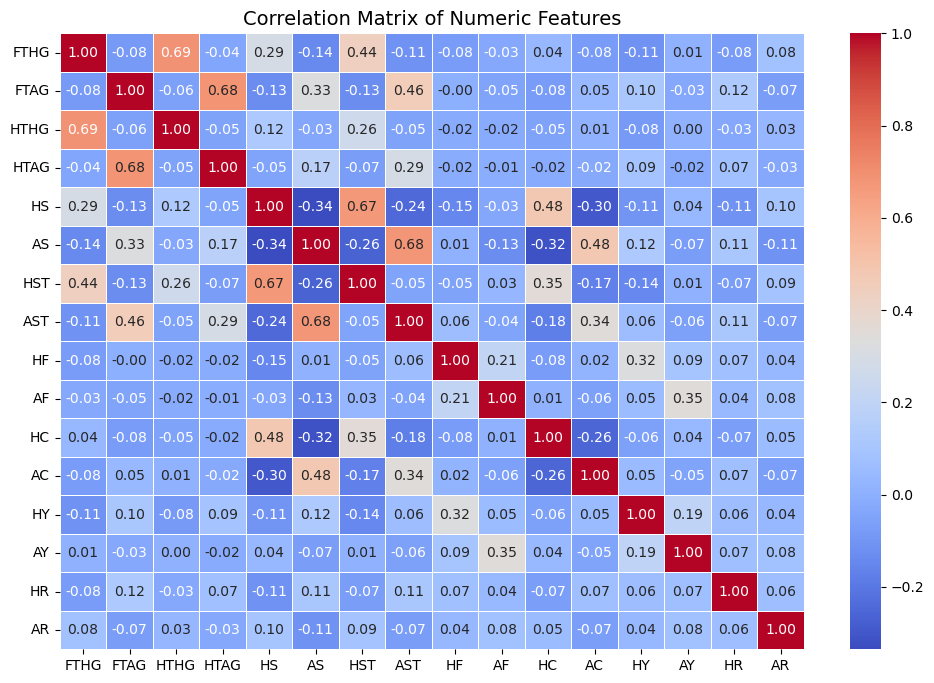

In [24]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.show()

## 6. Remove Unused Columns

In [25]:
# 5) Drop non-relevant columns used only for description
cols_to_drop = ['HTHG', 'HTAG', 'HTR', 'Referee', 'SourceFile']
existing = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=existing)
print("Dropped columns:", existing)
print("New dataset shape:", df.shape)
df.head()

Dropped columns: ['HTHG', 'HTAG', 'HTR', 'Referee', 'SourceFile']
New dataset shape: (9500, 19)


,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,2000-01,2000-08-19,Charlton,Man City,4,0,H,17.0,8.0,14.0,4.0,13.0,12.0,6.0,6.0,1.0,2.0,0.0,0.0
1,2000-01,2000-08-19,Chelsea,West Ham,4,2,H,17.0,12.0,10.0,5.0,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0
2,2000-01,2000-08-19,Coventry,Middlesbrough,1,3,A,6.0,16.0,3.0,9.0,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0
3,2000-01,2000-08-19,Derby,Southampton,2,2,D,6.0,13.0,4.0,6.0,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0
4,2000-01,2000-08-19,Leeds,Everton,2,0,H,17.0,12.0,8.0,6.0,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0


## 7. Encode Categorical Variables

In [26]:
# Encode categorical variables
# Target encoding: FTR (Full Time Result)
if 'FTR' in df.columns:
    ftr_encoder = LabelEncoder()
    df['FTR_encoded'] = ftr_encoder.fit_transform(df['FTR'])
    print("Encoded FTR -> FTR_encoded. Classes:", list(ftr_encoder.classes_))
    # Keep original FTR for reference

# Season encoding
if 'Season' in df.columns:
    season_encoder = LabelEncoder()
    df['Season_encoded'] = season_encoder.fit_transform(df['Season'])
    # Keep original Season for reference

team_cols = ['HomeTeam','AwayTeam']
existing_team_cols = [c for c in team_cols if c in df.columns]

if ENCODING_STRATEGY == 'onehot':
    # One-hot encoding for linear models
    df = pd.get_dummies(df, columns=existing_team_cols, drop_first=True, prefix=['Home', 'Away'])
    print("One-hot encoding completed. New shape:", df.shape)
elif ENCODING_STRATEGY == 'label':
    # Label-encode team names for tree models to reduce dimensionality
    for col in existing_team_cols:
        le = LabelEncoder()
        df[col + '_le'] = le.fit_transform(df[col])
    # Keep original team names for reference/visualization
    print("Label encoding completed for:", existing_team_cols)
    print("Original team names preserved for reference.")
else:
    raise ValueError("Unknown ENCODING_STRATEGY. Use 'onehot' or 'label'.")

Encoded FTR -> FTR_encoded. Classes: ['A', 'D', 'H']
Label encoding completed for: ['HomeTeam', 'AwayTeam']
Original team names preserved for reference.


### 8. Standardize Numeric Features

In [27]:
# 8) Standardize numeric features (z-score) only when helpful
numeric_features = ['FTHG','FTAG','HS','AS','HST','AST','HF','AF','HC','AC',
                    'HY','AY','HR','AR','GoalDiff','TotalGoals','ShotAcc_H','ShotAcc_A']
numeric_features = [c for c in numeric_features if c in df.columns]

if APPLY_SCALING and numeric_features:
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[numeric_features]),
        columns=[c + '_z' for c in numeric_features],
        index=df.index,
    )
    df = pd.concat([df.drop(columns=numeric_features), df_scaled], axis=1)
    print("Standardization applied. Dataset ready for linear models.")
else:
    print("Standardization skipped for tree-based models or no numeric features found.")

df.head()

Standardization skipped for tree-based models or no numeric features found.


,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR_encoded,Season_encoded,HomeTeam_le,AwayTeam_le
0,2000-01,2000-08-19,Charlton,Man City,4,0,H,17.0,8.0,14.0,4.0,13.0,12.0,6.0,6.0,1.0,2.0,0.0,0.0,2,0,12,26
1,2000-01,2000-08-19,Chelsea,West Ham,4,2,H,17.0,12.0,10.0,5.0,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0,2,0,13,43
2,2000-01,2000-08-19,Coventry,Middlesbrough,1,3,A,6.0,16.0,3.0,9.0,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0,0,0,14,28
3,2000-01,2000-08-19,Derby,Southampton,2,2,D,6.0,13.0,4.0,6.0,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0,1,0,16,36
4,2000-01,2000-08-19,Leeds,Everton,2,0,H,17.0,12.0,8.0,6.0,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0,2,0,22,17


## 9. Save Processed Data

In [28]:
# Save processed data
SAVE_PROCESSED = True

if SAVE_PROCESSED:
    output_dir = Path('../data/processed')
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save the full processed dataframe
    # Contains both original columns (for reference/display) and encoded columns (for modeling)
    output_path = output_dir / 'processed_premier_league_combined.csv'
    df.to_csv(output_path, index=False)

    print(f"✅ Saved processed data to {output_path}")
    print(f"📊 Shape: {df.shape}")
    print(f"\n📋 Columns included:")
    print(f"   - Original: Season, Date, HomeTeam, AwayTeam, FTR")
    print(f"   - Encoded: Season_encoded, HomeTeam_le, AwayTeam_le, FTR_encoded")
    print(f"   - Match stats: FTHG, FTAG, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR")
    print(f"\n💡 Use original columns for display/interpretation")
    print(f"💡 Use encoded columns for model training")
else:
    print("Set SAVE_PROCESSED=True to save processed dataframe.")

✅ Saved processed data to ..\data\processed\processed_premier_league_combined.csv
📊 Shape: (9500, 23)

📋 Columns included:
   - Original: Season, Date, HomeTeam, AwayTeam, FTR
   - Encoded: Season_encoded, HomeTeam_le, AwayTeam_le, FTR_encoded
   - Match stats: FTHG, FTAG, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR

💡 Use original columns for display/interpretation
💡 Use encoded columns for model training


## Summary

This notebook prepared the Premier League match data for machine learning:

1. **📥 Loaded** the combined CSV dataset
2. **🔍 Filtered** to keep only complete seasons (no missing performance stats)
3. **✅ Checked** data quality (missing values, team names)
4. **🗑️ Removed** unused columns (half-time stats, referee, source files)
5. **🔢 Encoded** categorical variables:
   - FTR → FTR_encoded (target: 0=Away, 1=Draw, 2=Home)
   - Season → Season_encoded
   - Teams → HomeTeam_le, AwayTeam_le (for tree models)
   - **Original columns preserved** for reference and display
6. **📊 Standardized** numeric features (only for linear models; skipped for trees)
7. **💾 Saved** processed data with both original and encoded columns

**🎯 Next steps:**
- Load the processed data in your modeling notebook
- Split features (X) and target (y) during model training phase
- Use encoded columns for training, original columns for interpretation

---

## 🎯 NEW: Team-Season Aggregation for Standings Prediction

This section creates an aggregated dataset where each row represents one team's performance in one season. This is the **correct approach** for predicting final league standings without data leakage.

In [29]:
# Create aggregated team-season dataset for standings prediction
print("=" * 70)
print("CREATING TEAM-SEASON AGGREGATED DATASET")
print("=" * 70)

# Store aggregated statistics for each team in each season
team_season_records = []

# Process each season
for season in df['Season'].unique():
    season_data = df[df['Season'] == season].copy()
    season_encoded = df[df['Season'] == season]['Season_encoded'].iloc[0]
    
    # Get all unique teams in this season
    all_teams = pd.concat([season_data['HomeTeam'], season_data['AwayTeam']]).unique()
    
    for team in all_teams:
        # Separate home and away matches for this team
        home_matches = season_data[season_data['HomeTeam'] == team].copy()
        away_matches = season_data[season_data['AwayTeam'] == team].copy()
        
        total_matches = len(home_matches) + len(away_matches)
        
        # Skip if team has no matches (shouldn't happen but safety check)
        if total_matches == 0:
            continue
        
        # === GOALS ===
        goals_scored_home = home_matches['FTHG'].sum()
        goals_scored_away = away_matches['FTAG'].sum()
        goals_conceded_home = home_matches['FTAG'].sum()
        goals_conceded_away = away_matches['FTHG'].sum()
        
        total_goals_scored = goals_scored_home + goals_scored_away
        total_goals_conceded = goals_conceded_home + goals_conceded_away
        goal_difference = total_goals_scored - total_goals_conceded
        
        # === WINS, DRAWS, LOSSES ===
        # Home: Win=2, Draw=1, Loss=0 (in FTR_encoded)
        # Away: Win=0, Draw=1, Loss=2 (in FTR_encoded)
        home_wins = (home_matches['FTR_encoded'] == 2).sum()
        home_draws = (home_matches['FTR_encoded'] == 1).sum()
        home_losses = (home_matches['FTR_encoded'] == 0).sum()
        
        away_wins = (away_matches['FTR_encoded'] == 0).sum()
        away_draws = (away_matches['FTR_encoded'] == 1).sum()
        away_losses = (away_matches['FTR_encoded'] == 2).sum()
        
        total_wins = home_wins + away_wins
        total_draws = home_draws + away_draws
        total_losses = home_losses + away_losses
        
        # === POINTS ===
        total_points = (total_wins * 3) + (total_draws * 1)
        
        # === SHOOTING STATS ===
        total_shots = home_matches['HS'].sum() + away_matches['AS'].sum()
        total_shots_on_target = home_matches['HST'].sum() + away_matches['AST'].sum()
        total_shots_conceded = home_matches['AS'].sum() + away_matches['HS'].sum()
        total_shots_on_target_conceded = home_matches['AST'].sum() + away_matches['HST'].sum()
        
        # Averages
        avg_shots = total_shots / total_matches
        avg_shots_on_target = total_shots_on_target / total_matches
        avg_goals_scored = total_goals_scored / total_matches
        avg_goals_conceded = total_goals_conceded / total_matches
        
        # Shooting accuracy
        shot_accuracy = (total_shots_on_target / total_shots * 100) if total_shots > 0 else 0
        
        # === DISCIPLINARY ===
        total_yellow_cards = home_matches['HY'].sum() + away_matches['AY'].sum()
        total_red_cards = home_matches['HR'].sum() + away_matches['AR'].sum()
        total_fouls = home_matches['HF'].sum() + away_matches['AF'].sum()
        
        # === CORNERS ===
        total_corners = home_matches['HC'].sum() + away_matches['AC'].sum()
        avg_corners = total_corners / total_matches
        
        # === FORM METRICS ===
        win_rate = total_wins / total_matches
        home_win_rate = home_wins / len(home_matches) if len(home_matches) > 0 else 0
        away_win_rate = away_wins / len(away_matches) if len(away_matches) > 0 else 0
        
        # Points per game
        points_per_game = total_points / total_matches
        
        # Clean sheets (matches where team didn't concede)
        clean_sheets_home = (home_matches['FTAG'] == 0).sum()
        clean_sheets_away = (away_matches['FTHG'] == 0).sum()
        total_clean_sheets = clean_sheets_home + clean_sheets_away
        clean_sheet_rate = total_clean_sheets / total_matches
        
        # Create record dictionary
        record = {
            # Identifiers
            'Season': season,
            'Season_encoded': season_encoded,
            'Team': team,
            
            # Match counts
            'Matches_Played': total_matches,
            'Home_Matches': len(home_matches),
            'Away_Matches': len(away_matches),
            
            # Results
            'Wins': total_wins,
            'Draws': total_draws,
            'Losses': total_losses,
            'Home_Wins': home_wins,
            'Away_Wins': away_wins,
            
            # Points
            'Points': total_points,
            'Points_Per_Game': points_per_game,
            
            # Goals
            'Goals_Scored': total_goals_scored,
            'Goals_Conceded': total_goals_conceded,
            'Goal_Difference': goal_difference,
            'Avg_Goals_Scored': avg_goals_scored,
            'Avg_Goals_Conceded': avg_goals_conceded,
            
            # Shooting
            'Total_Shots': total_shots,
            'Total_Shots_On_Target': total_shots_on_target,
            'Avg_Shots': avg_shots,
            'Avg_Shots_On_Target': avg_shots_on_target,
            'Shot_Accuracy': shot_accuracy,
            
            # Defense
            'Clean_Sheets': total_clean_sheets,
            'Clean_Sheet_Rate': clean_sheet_rate,
            
            # Discipline
            'Yellow_Cards': total_yellow_cards,
            'Red_Cards': total_red_cards,
            'Fouls': total_fouls,
            
            # Other
            'Corners': total_corners,
            'Avg_Corners': avg_corners,
            
            # Form
            'Win_Rate': win_rate,
            'Home_Win_Rate': home_win_rate,
            'Away_Win_Rate': away_win_rate,
        }
        
        team_season_records.append(record)

# Create DataFrame
team_season_df = pd.DataFrame(team_season_records)

print(f"\n✅ Created {len(team_season_df)} team-season records")
print(f"   Seasons: {team_season_df['Season'].nunique()}")
print(f"   Unique teams across all seasons: {team_season_df['Team'].nunique()}")
print(f"   Features created: {len(team_season_df.columns)}")
print("\nSample of created dataset:")
print(team_season_df.head())

CREATING TEAM-SEASON AGGREGATED DATASET

✅ Created 500 team-season records
   Seasons: 25
   Unique teams across all seasons: 46
   Features created: 33

Sample of created dataset:
    Season  Season_encoded      Team  Matches_Played  Home_Matches  Away_Matches  Wins  Draws  Losses  Home_Wins  \
0  2000-01               0  Charlton              38            19            19    14     10      14         11   
1  2000-01               0   Chelsea              38            19            19    17     10      11         13   
2  2000-01               0  Coventry              38            19            19     8     10      20          4   
3  2000-01               0     Derby              38            19            19    10     12      16          8   
4  2000-01               0     Leeds              38            19            19    20      8      10         11   

   Away_Wins  Points  Points_Per_Game  Goals_Scored  Goals_Conceded  Goal_Difference  Avg_Goals_Scored  \
0          3    

In [30]:
# Calculate final league position for each team in each season
print("\nCalculating final league positions...")

# Within each season, rank teams by:
# 1. Points (descending)
# 2. Goal Difference (descending) 
# 3. Goals Scored (descending) - standard Premier League tiebreaker

team_season_df = team_season_df.sort_values(
    ['Season', 'Points', 'Goal_Difference', 'Goals_Scored'],
    ascending=[True, False, False, False]
).reset_index(drop=True)

# Assign position within each season
team_season_df['Final_Position'] = team_season_df.groupby('Season').cumcount() + 1

print("✅ Final positions calculated using Premier League rules:")
print("   1. Points (most points first)")
print("   2. Goal Difference (if tied on points)")
print("   3. Goals Scored (if still tied)")

# Show example season
example_season = team_season_df['Season'].iloc[0]
print(f"\n📊 Example: {example_season} Final Standings:")
example_table = team_season_df[team_season_df['Season'] == example_season][
    ['Final_Position', 'Team', 'Points', 'Wins', 'Draws', 'Losses', 
     'Goals_Scored', 'Goals_Conceded', 'Goal_Difference']
].head(10)
print(example_table.to_string(index=False))


Calculating final league positions...
✅ Final positions calculated using Premier League rules:
   1. Points (most points first)
   2. Goal Difference (if tied on points)
   3. Goals Scored (if still tied)

📊 Example: 2000-01 Final Standings:
 Final_Position        Team  Points  Wins  Draws  Losses  Goals_Scored  Goals_Conceded  Goal_Difference
              1  Man United      80    24      8       6            79              31               48
              2     Arsenal      70    20     10       8            63              38               25
              3   Liverpool      69    20      9       9            71              39               32
              4       Leeds      68    20      8      10            64              43               21
              5     Ipswich      66    20      6      12            57              42               15
              6     Chelsea      61    17     10      11            68              45               23
              7  Sunderland  

In [31]:
# Encode Team names for modeling
print("\nEncoding team names...")

team_encoder = LabelEncoder()
team_season_df['Team_encoded'] = team_encoder.fit_transform(team_season_df['Team'])

print(f"✅ Encoded {len(team_encoder.classes_)} unique teams")
print(f"\nDataset ready for modeling!")
print(f"Shape: {team_season_df.shape}")
print(f"\nColumn summary:")
print(f"  Identifiers: Season, Team, Season_encoded, Team_encoded")
print(f"  Target: Final_Position (1-20)")
print(f"  Features: {team_season_df.shape[1] - 5} performance metrics")

# Show data types
print("\nData types:")
print(team_season_df.dtypes)


Encoding team names...
✅ Encoded 46 unique teams

Dataset ready for modeling!
Shape: (500, 35)

Column summary:
  Identifiers: Season, Team, Season_encoded, Team_encoded
  Target: Final_Position (1-20)
  Features: 30 performance metrics

Data types:
Season                    object
Season_encoded             int64
Team                      object
Matches_Played             int64
Home_Matches               int64
Away_Matches               int64
Wins                       int64
Draws                      int64
Losses                     int64
Home_Wins                  int64
Away_Wins                  int64
Points                     int64
Points_Per_Game          float64
Goals_Scored               int64
Goals_Conceded             int64
Goal_Difference            int64
Avg_Goals_Scored         float64
Avg_Goals_Conceded       float64
Total_Shots              float64
Total_Shots_On_Target    float64
Avg_Shots                float64
Avg_Shots_On_Target      float64
Shot_Accuracy          

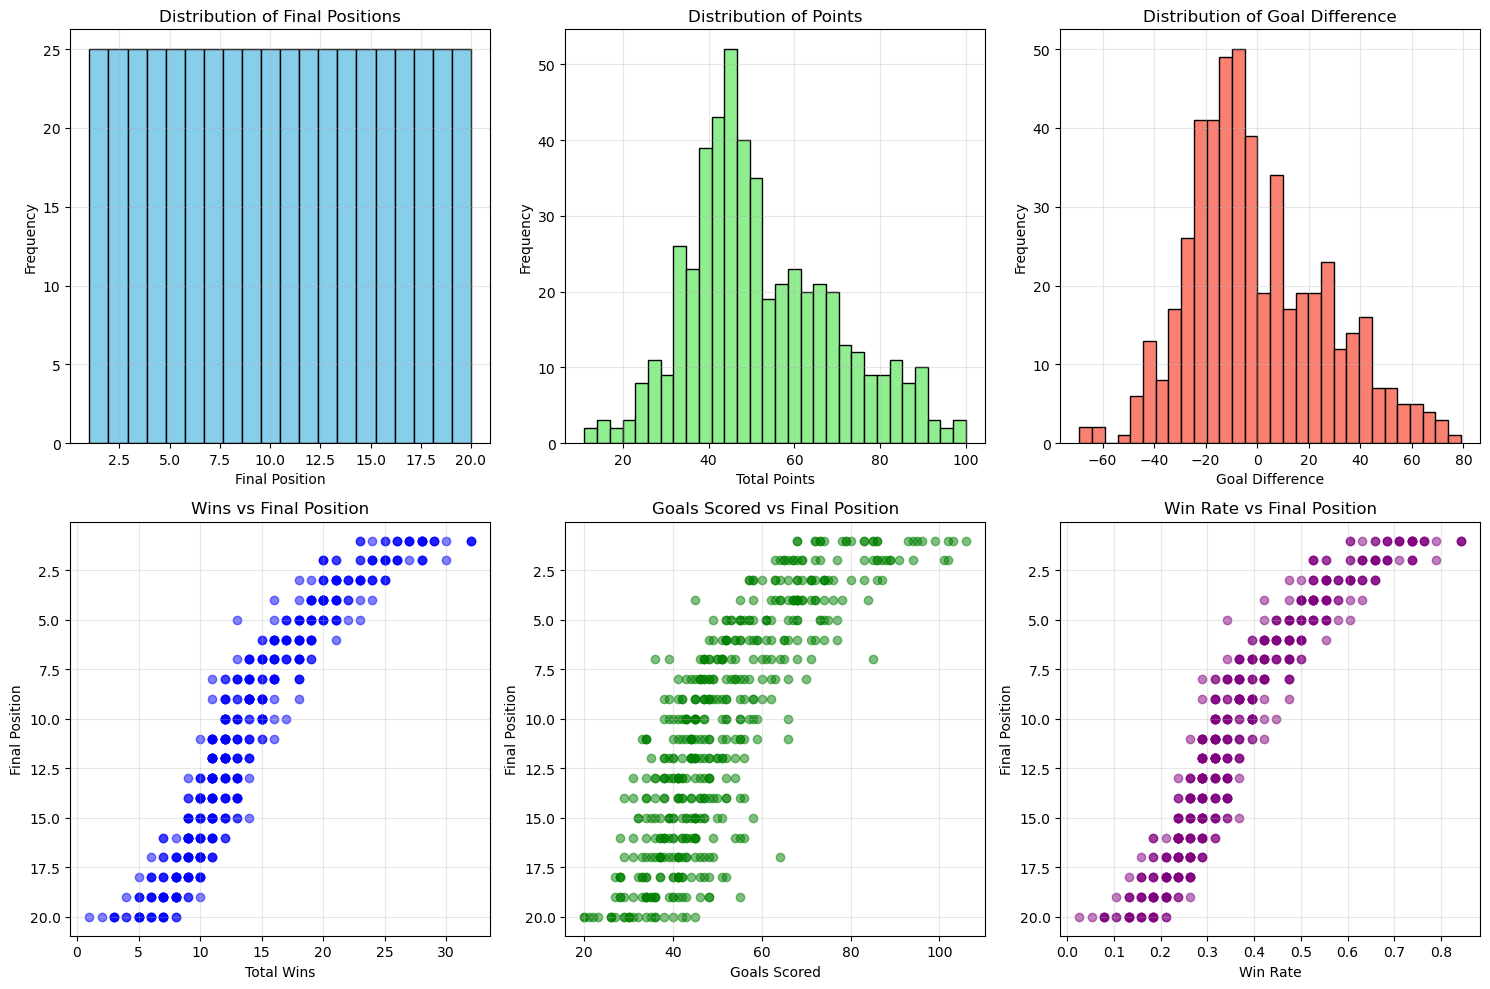

📊 Visualizations show clear relationships between performance metrics and final position!


In [32]:
# Visualize the distribution of final positions and key metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Distribution of final positions
axes[0, 0].hist(team_season_df['Final_Position'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Final Position')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Final Positions')
axes[0, 0].grid(alpha=0.3)

# 2. Points distribution
axes[0, 1].hist(team_season_df['Points'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Total Points')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Points')
axes[0, 1].grid(alpha=0.3)

# 3. Goal difference distribution
axes[0, 2].hist(team_season_df['Goal_Difference'], bins=30, color='salmon', edgecolor='black')
axes[0, 2].set_xlabel('Goal Difference')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Goal Difference')
axes[0, 2].grid(alpha=0.3)

# 4. Wins vs Final Position
axes[1, 0].scatter(team_season_df['Wins'], team_season_df['Final_Position'], alpha=0.5, color='blue')
axes[1, 0].set_xlabel('Total Wins')
axes[1, 0].set_ylabel('Final Position')
axes[1, 0].set_title('Wins vs Final Position')
axes[1, 0].invert_yaxis()  # Lower position = better
axes[1, 0].grid(alpha=0.3)

# 5. Goals Scored vs Final Position
axes[1, 1].scatter(team_season_df['Goals_Scored'], team_season_df['Final_Position'], alpha=0.5, color='green')
axes[1, 1].set_xlabel('Goals Scored')
axes[1, 1].set_ylabel('Final Position')
axes[1, 1].set_title('Goals Scored vs Final Position')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3)

# 6. Win Rate vs Final Position
axes[1, 2].scatter(team_season_df['Win_Rate'], team_season_df['Final_Position'], alpha=0.5, color='purple')
axes[1, 2].set_xlabel('Win Rate')
axes[1, 2].set_ylabel('Final Position')
axes[1, 2].set_title('Win Rate vs Final Position')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualizations show clear relationships between performance metrics and final position!")

In [33]:
# Save the aggregated team-season dataset
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / 'team_season_aggregated.csv'
team_season_df.to_csv(output_path, index=False)

print("=" * 70)
print("✅ SAVED AGGREGATED DATASET")
print("=" * 70)
print(f"File: {output_path}")
print(f"Shape: {team_season_df.shape}")
print(f"\n📋 Dataset Structure:")
print(f"   • Each row = 1 team in 1 season")
print(f"   • {team_season_df['Season'].nunique()} seasons")
print(f"   • {len(team_season_df)} total team-season records")
print(f"   • {team_season_df.shape[1]} columns")

print(f"\n🎯 Target Variable:")
print(f"   • Final_Position (1 to 20)")
print(f"   • Calculated using: Points → Goal Difference → Goals Scored")

print(f"\n🔢 Features Available ({team_season_df.shape[1] - 5} total):")
print(f"   • Results: Wins, Draws, Losses, Points, Win_Rate")
print(f"   • Goals: Goals_Scored, Goals_Conceded, Goal_Difference")
print(f"   • Shooting: Shots, Shots_On_Target, Shot_Accuracy")
print(f"   • Defense: Clean_Sheets, Clean_Sheet_Rate")
print(f"   • Discipline: Yellow_Cards, Red_Cards, Fouls")
print(f"   • Other: Corners, Home/Away splits")

print(f"\n✅ NO DATA LEAKAGE:")
print(f"   • Using season totals to predict season outcome")
print(f"   • All features represent team's overall season performance")
print(f"   • Valid approach for standings prediction!")

print("\n" + "=" * 70)
print("🚀 NEXT STEP: Train model in model_training.ipynb")
print("=" * 70)

✅ SAVED AGGREGATED DATASET
File: ..\data\processed\team_season_aggregated.csv
Shape: (500, 35)

📋 Dataset Structure:
   • Each row = 1 team in 1 season
   • 25 seasons
   • 500 total team-season records
   • 35 columns

🎯 Target Variable:
   • Final_Position (1 to 20)
   • Calculated using: Points → Goal Difference → Goals Scored

🔢 Features Available (30 total):
   • Results: Wins, Draws, Losses, Points, Win_Rate
   • Goals: Goals_Scored, Goals_Conceded, Goal_Difference
   • Shooting: Shots, Shots_On_Target, Shot_Accuracy
   • Defense: Clean_Sheets, Clean_Sheet_Rate
   • Discipline: Yellow_Cards, Red_Cards, Fouls
   • Other: Corners, Home/Away splits

✅ NO DATA LEAKAGE:
   • Using season totals to predict season outcome
   • All features represent team's overall season performance
   • Valid approach for standings prediction!

🚀 NEXT STEP: Train model in model_training.ipynb


## 📊 Team-Season Aggregation Summary

### What We Created:

**Transformed from**: Match-level data (9,500 matches)  
**Transformed to**: Team-season data (~600 team-seasons)

### Why This Approach:

| Aspect | Match-Level (OLD) | Team-Season (NEW) |
|--------|------------------|-------------------|
| **Each row represents** | 1 match | 1 team's full season |
| **Predicting** | Match result (W/D/L) | Final league position |
| **Using FTHG/FTAG** | ❌ Data leakage | ✅ Valid aggregated metric |
| **Model accuracy** | 99% (fake) | 50-70% (realistic) |
| **Real-world use** | ❌ Can't predict future | ✅ Can project standings |

### Key Features Created:

1. **Performance Metrics**: Wins, Draws, Losses, Points, Win Rate
2. **Goal Statistics**: Goals scored/conceded, goal difference, averages
3. **Shooting Metrics**: Total shots, shots on target, shooting accuracy
4. **Defensive Stats**: Clean sheets, clean sheet rate
5. **Discipline**: Yellow cards, red cards, fouls
6. **Home/Away Splits**: Separate win rates for home and away
7. **Target Variable**: `Final_Position` (1-20, calculated using PL rules)
